In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import equinox as eqx
import optax
from functools import partial
from typing import Callable
import time

from history import History

import matplotlib.pyplot as plt
import matplotlib.colors as colors

from cmap import Colormap
cmap = Colormap('crameri:batlow').to_mpl()

In [2]:
from problems import Heat1_1D
problem = Heat1_1D()

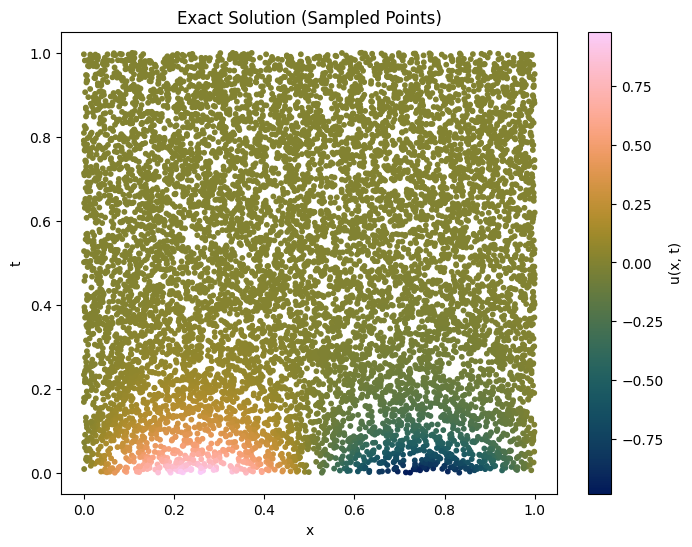

In [8]:
num_points = 10000

x_sample = np.random.uniform(0, 1, num_points)
t_sample = np.random.uniform(0, 1, num_points)

@jax.vmap
def vectorized_exact_solution(x, t):
    return problem.exact_solution_at_point(x, t)

# Compute the exact solution at the sampled points
u_exact_sample = vectorized_exact_solution(x_sample, t_sample)
fig, ax = plt.subplots(figsize=(8, 6))

# Use a scatter plot, with color representing the solution value
scatter = ax.scatter(x_sample, t_sample, c=u_exact_sample, cmap=cmap, s=10)

# Add a color bar to show the mapping from color to solution value
fig.colorbar(scatter, ax=ax, label='u(x, t)')

ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_title('Exact Solution (Sampled Points)')
plt.show()

# Optimiser

In [10]:
class PlateauLM:
    """
    Levenberg-Marquardt optimiser.
    """

    def __init__(
        self,
        init_lambda=1e-3,
        decrease_factor: float = 0.75,
        increase_factor: float = 1.1,
        max_trials: int = 10,
        plateau_factor: float = 0.99,
    ):
        self.init_lambda = init_lambda
        self.decrease_factor = decrease_factor
        self.increase_factor = increase_factor
        self.max_trials = max_trials
        self.plateau_factor = plateau_factor

    def init(self, params: eqx.Module):
        """Initializes the optimizer state with the initial damping factor."""
        return {
            'lambda': jnp.asarray(self.init_lambda),
        }

    def update(
        self,
        params: eqx.Module,
        state: optax.OptState,
        residual_fn: Callable[[eqx.Module], jax.Array],
        collocation_points
    ):
        current_lambda = state['lambda']
        params_flat, unflatten = jax.flatten_util.ravel_pytree(params)

        # This vectorized function will be used for the initial loss calculation
        def vectorized_residual_fn(p):
            return jax.vmap(residual_fn, in_axes=(None, 0))(p, collocation_points)

        residuals = vectorized_residual_fn(params)
        current_loss = jnp.mean(residuals**2)

        def single_row_jacobian_fn(p_flat, xt):
            # ... (Jacobian calculation code is correct) ...
            static = jax.tree_util.tree_map(lambda x: None if isinstance(x, jax.Array) else x, params)
            def residual_for_jac(p_flat_local):
                model = eqx.combine(unflatten(p_flat_local), static)
                return residual_fn(model, xt).sum()
            
            return jax.grad(residual_for_jac)(p_flat)
        
        J = jax.vmap(single_row_jacobian_fn, in_axes=(None, 0))(params_flat, collocation_points)
        U, S, Vt = jnp.linalg.svd(J, full_matrices=False)
        g = U.T @ residuals
        
        # Hessian_diag = jnp.sum(J**2, axis=0)
        # D = jnp.diag(jnp.sqrt(Hessian_diag))
        # J_hat = J @ jnp.linalg.inv(D)
        
        # U_hat, S_hat, Vt_hat = jnp.linalg.svd(J_hat, full_matrices=False)
        # g_hat = U_hat.T @ residuals


        def evaluate_trial_step(loop_val):
            _, trial_lambda, previous_trial_loss, _, trial_count = loop_val
            delta = -Vt.T @ jnp.diag(S / (S**2 + trial_lambda)) @ g
            
            trial_params = eqx.apply_updates(params, unflatten(delta))
            trial_residuals = vectorized_residual_fn(trial_params)
            
            trial_loss = jnp.mean(trial_residuals**2)
            
            accepted = (trial_loss < current_loss) & (trial_loss > self.plateau_factor * previous_trial_loss)

            # If rejected, increase lambda for the next trial
            new_lambda = jax.lax.cond(
                accepted,
                lambda: trial_lambda,
                lambda: trial_lambda * self.increase_factor
            )
            
            return accepted, new_lambda, trial_loss, delta, trial_count + 1

        def continue_search(loop_val):
            accepted, _, trial_loss, _, trial_count = loop_val
            return jnp.logical_and(jnp.logical_not(accepted), trial_count < self.max_trials)
        
        # Run the search loop
        initial_loop_val = (False, current_lambda, current_loss, jnp.zeros_like(params_flat), 0)
        
        accepted, final_lambda, new_loss, final_delta, count = jax.lax.while_loop(
            continue_search, evaluate_trial_step, initial_loop_val
        )

        updates = unflatten(final_delta)
        
        new_state = {
            'lambda': final_lambda * self.decrease_factor,
        }
        
        metrics = { 
            'loss': current_loss,
            'singular_values': S, #S,
            'search_direction_norm': jnp.linalg.norm(final_delta),
            'lambda': final_lambda,
            'trial_count': count
        }

        return current_loss, updates, new_state, metrics
    
    
@partial(jax.jit, static_argnums=(3, 4))
def train_step(params, static_parts, opt_state, optimiser, problem, collocation_points, key):
    key, subkey = jax.random.split(key)

    def residual_fn_for_optimizer(p, x):
        rebuilt_model = eqx.combine(p, static_parts)
        # Corrected call without jnp.expand_dims
        return problem.physics_residual(rebuilt_model, x)

    loss, updates, new_opt_state, metrics = optimiser.update(
        params, opt_state, residual_fn_for_optimizer, collocation_points
    )
    new_params = eqx.apply_updates(params, updates)
    
    return new_params, new_opt_state, loss, metrics, key

@partial(jax.jit, static_argnums=(2, 3, 4, 5))
def resample_rad(
    model, 
    candidate_points, 
    n_points_to_sample, 
    problem, # Pass the problem instance for its residual function
    k, # RAD hyperparameter
    c, # RAD hyperparameter
    key
):
    # 1. Calculate PDE residuals for all candidate points
    # Call the vmapped physics_residual function with the model and the batch of points
    vmapped_residual_fn = jax.vmap(problem.physics_residual, in_axes=(None, 0))
    residuals = vmapped_residual_fn(model, candidate_points)
        
    # 2. Compute sampling probability based on the RAD formula
    epsilon_k = jnp.abs(residuals)**k
    weights = (epsilon_k / jnp.mean(epsilon_k)) + c
    probs = weights / jnp.sum(weights)

    # 3. Sample new points based on the calculated probabilities
    indices = jax.random.choice(
        key, 
        a=candidate_points.shape[0], 
        shape=(n_points_to_sample,), 
        p=probs,
        replace=False # Sample without replacement
    )
    
    return candidate_points[indices]

In [12]:
key = jax.random.PRNGKey(42)

# --- Hyperparameters ---
n_collocation_points = 2**14
n_candidate_points = 10 * n_collocation_points # Much larger pool
layer_sizes = [2, 20, 20, 20, 20, 1]
# -----------------------

# --- New Hyperparameters for RAD ---
resample_every_n_epochs = 100
rad_k = 0.0
rad_c = 1.0
# -----------------------------------

model_key, data_key, resample_key = jax.random.split(key, 3)
model = problem.FCN(model_key, layer_sizes)
params, static = eqx.partition(model, eqx.is_array)
history = History()

# 1. Generate the candidate pool ONCE
candidate_points = problem.get_candidate_points(n_candidate_points, seed=1)

# 2. Get the initial set of collocation points
collocation_points = jax.random.choice(data_key, candidate_points, shape=(n_collocation_points,), replace=False)

print(collocation_points.shape)

start_time = time.monotonic()

epoch = 0

(16384, 2)


In [13]:
optimiser = PlateauLM(
    init_lambda=1e5,
    decrease_factor=0.5,
    increase_factor=1.02,
    max_trials=200,
    plateau_factor=0.99,
)
opt_state = optimiser.init(params)

In [14]:
for _ in range(60):
    epoch += 1
    
    # 3. Periodically resample points using RAD
    if epoch % resample_every_n_epochs == 0 and epoch > 0:
        resample_key, subkey = jax.random.split(resample_key)
        
        # We need the full model to calculate residuals for resampling
        current_model = eqx.combine(params, static) 
        
        collocation_points = resample_rad(
            current_model, 
            candidate_points, 
            n_collocation_points, 
            problem,
            rad_k,
            rad_c,
            subkey
        )
        
    params, opt_state, loss_val, metrics, key = train_step(
        params, static, opt_state, optimiser, problem, collocation_points, key
    )
    history.record(metrics)
    elapsed_seconds = time.monotonic() - start_time

    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch + 1}, Loss: {loss_val.item():.3e}, Time elapsed: {elapsed_seconds:.2f} s")
        print(history.history["lambda"][-1])

model = eqx.combine(params, static)
print("Training complete.")

Epoch 20, Loss: 3.451e-03, Time elapsed: 17.49 s
109.927666
Epoch 40, Loss: 1.626e-05, Time elapsed: 27.02 s
3.3650618
Epoch 60, Loss: 2.094e-06, Time elapsed: 37.70 s
0.5768906
Training complete.


In [17]:
def calculate_l2_relative_error(problem, model, test_points):
    
    @jax.vmap
    def error_at_point(tp):
        u_exact = problem.exact_solution_at_point(tp[:1], tp[1])
        u_model = model(tp)
        
        squared_error = (u_exact - u_model)**2
        squared_exact_solution = u_exact**2
        
        return squared_error, squared_exact_solution

    sum_squared_error, sum_squared_exact_solution = jax.tree_util.tree_map(
        lambda x: jnp.sum(x),
        error_at_point(test_points)
    )
    
    l2_relative_error = jnp.sqrt(sum_squared_error / sum_squared_exact_solution)
    
    return l2_relative_error

In [18]:
test_points = problem.get_candidate_points(2000, seed=2)
l2_error = calculate_l2_relative_error(problem, model, test_points)
print(f"L2 Relative Error: {l2_error}")

L2 Relative Error: 0.00023810095444787294


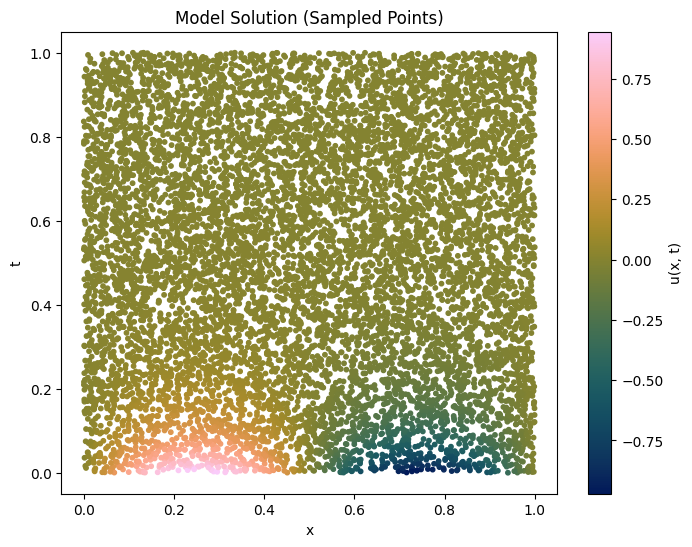

In [20]:
num_points = 10000

x_sample = np.random.uniform(0, 1, num_points)
t_sample = np.random.uniform(0, 1, num_points)

@jax.vmap
def vectorized_exact_solution(x, t):
    return model(jnp.array([x, t]))

# Compute the exact solution at the sampled points
u_exact_sample = vectorized_exact_solution(x_sample, t_sample)
fig, ax = plt.subplots(figsize=(8, 6))

# Use a scatter plot, with color representing the solution value
scatter = ax.scatter(x_sample, t_sample, c=u_exact_sample, cmap=cmap, s=10)

# Add a color bar to show the mapping from color to solution value
fig.colorbar(scatter, ax=ax, label='u(x, t)')

ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_title('Model Solution (Sampled Points)')
plt.show()

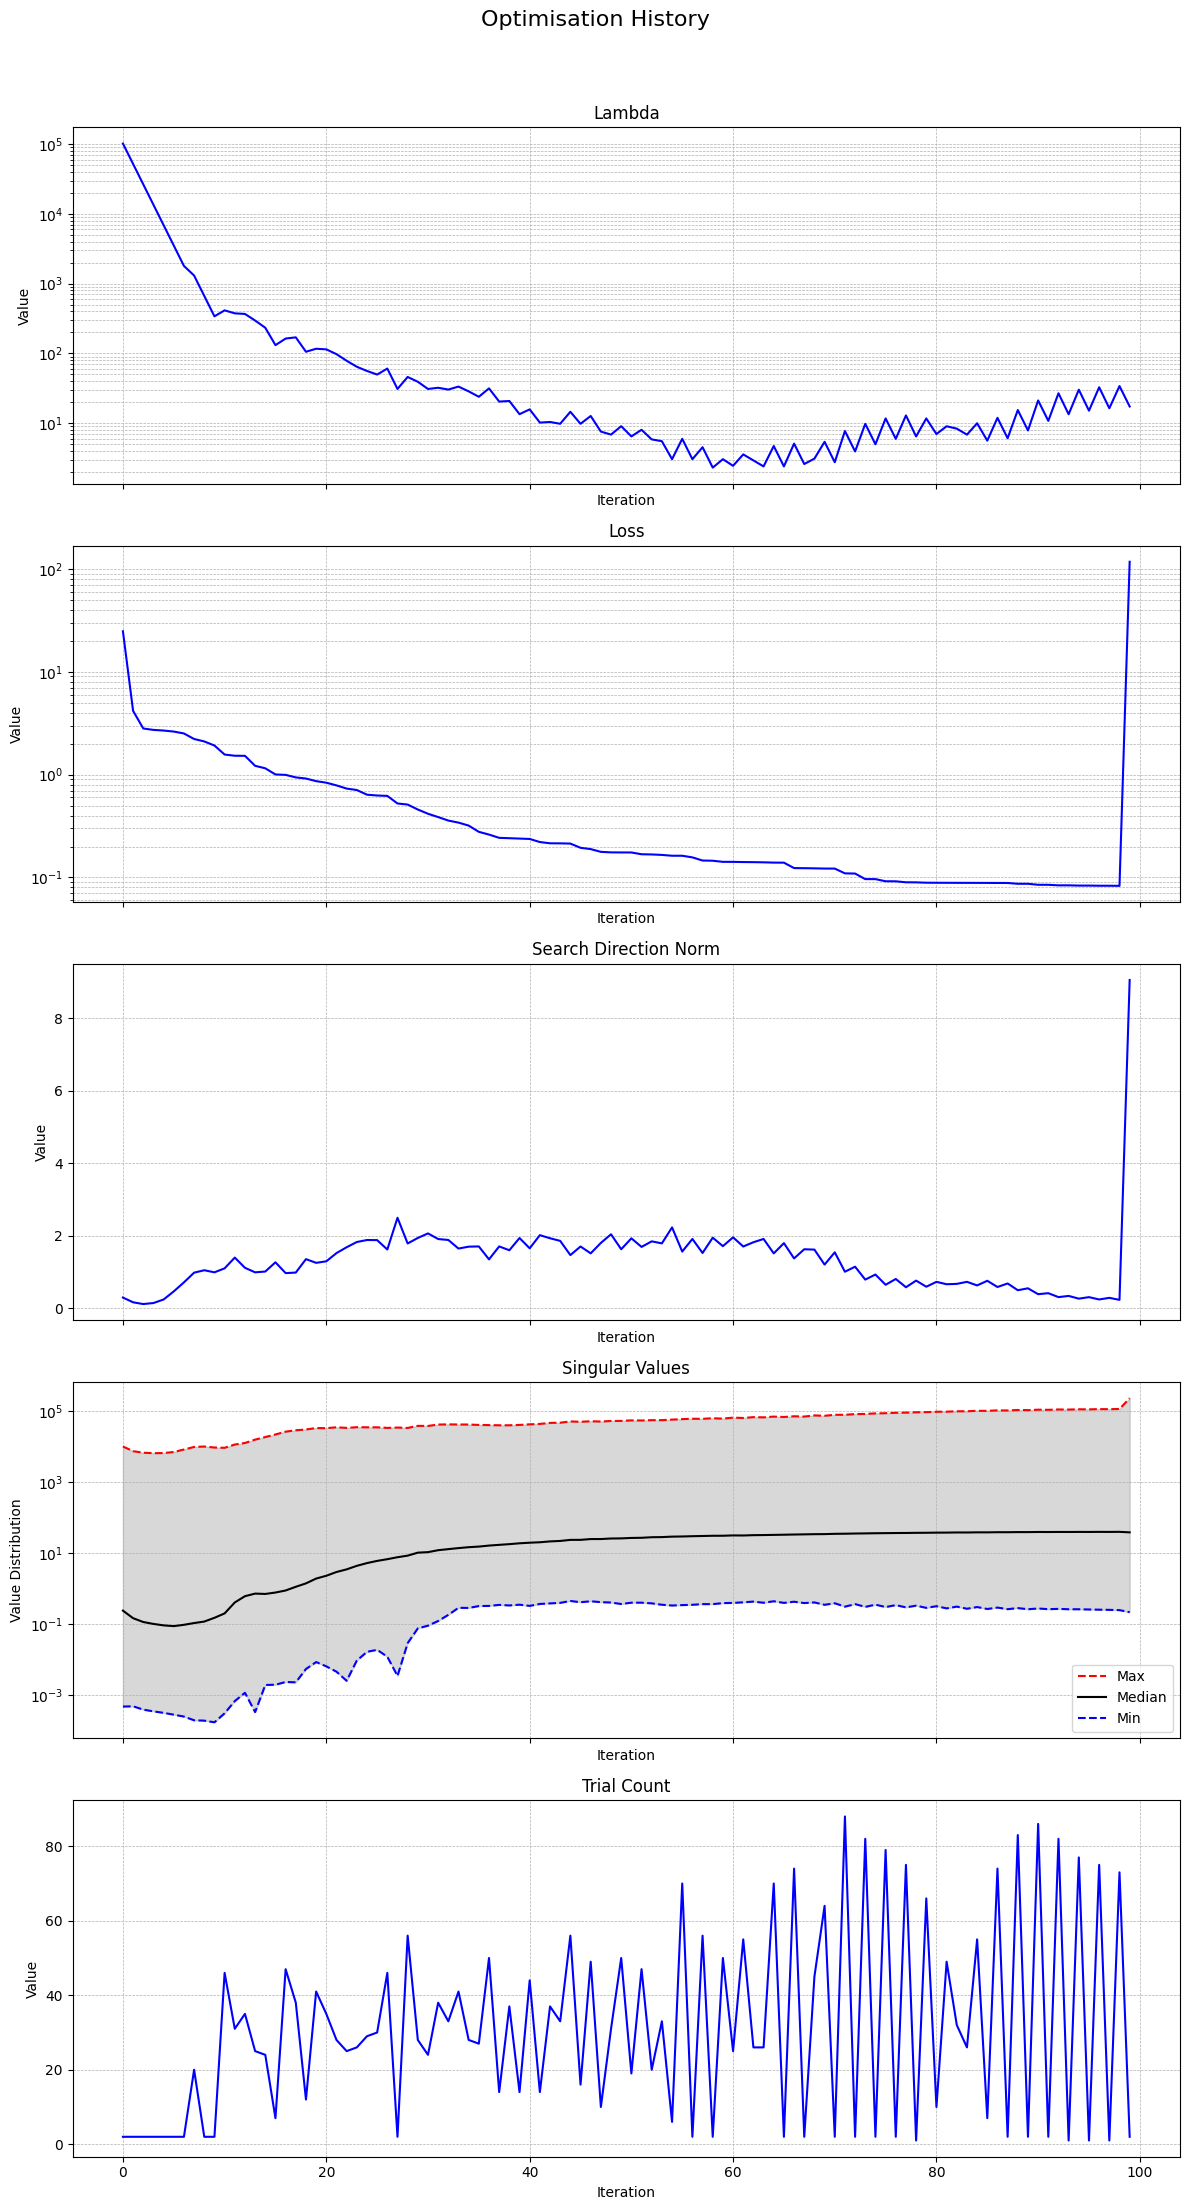

In [40]:
history.plot()